In [54]:
%reset -f

import pandas as pd
import numpy as np
import scipy as sci
import sympy as sym
import math
import networkx as nx
import matplotlib.pyplot as plt
import time
import gurobipy as gp
import igraph as ig
import pickle


from numpy import sqrt, exp, log, sin, cos, pi, polyfit, polyval, vander
from numpy.linalg import inv, pinv, det, matrix_rank, cond, lstsq, solve
from scipy.integrate import solve_ivp
from gurobipy import GRB
from itertools import combinations
from pyinstrument import Profiler
from numba import jit

plt.style.use('default')                                    # 使用默认风格
plt.rcParams['figure.facecolor'] = 'white'                  # 将图形的背景颜色设置为白色
plt.rcParams['font.family'] = 'YaHei Consolas Hybrid'       # 字体确认
plt.rcParams['font.size'] = 12                              # 字体大小
plt.rcParams['axes.unicode_minus'] = False                  # 正常显示负号
%matplotlib inline

In [56]:
## 第四问设置增加的给水点
addWaternodes = ['J21', 'J27']
# addWaternodes = ['J27', 'J60']

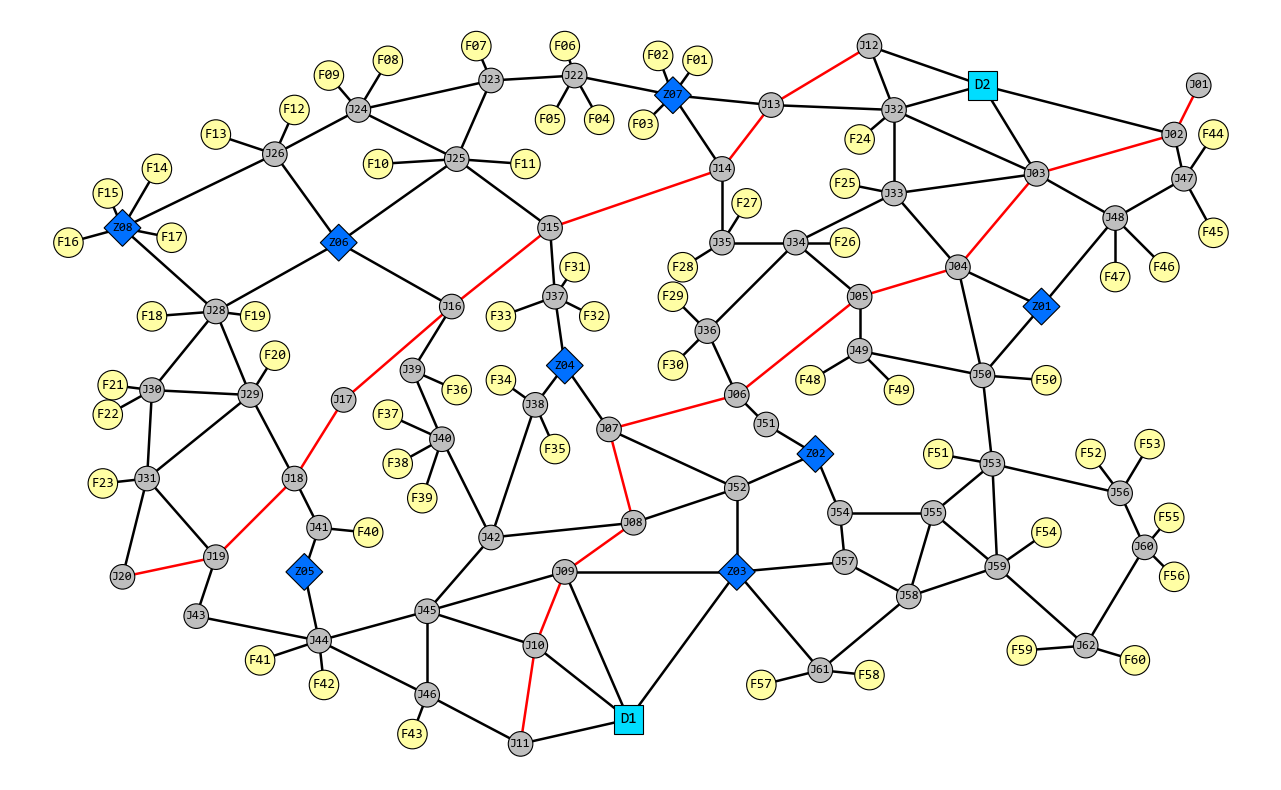

In [57]:
##数据处理

# 点总数
nodecnts = 130
# 喷水车数目
carcnts = 20
# 名称--点序号
node_number = {}
# 点序号--坐标
num2pos = {}
# 边的信息
edgeInfo = np.zeros((nodecnts, nodecnts))
# 停靠点数目
stopNodes = 2
# 工作点数目
workingNodes = 0
working_map = {}
# 给水点数目
waterNodes = 0
water_map = {}
# 正常点的数目
normalNodes = 0
normal_map = {}
# A车、B车在1级路的速度
speed1 = (60, 50)
# A车、B车在2级路的速度       
speed2 = (45, 30)
# A车、B车的作业时间
workingcost = (1/3, 1/4)
# 构建花费矩阵
# fullcostmat[0][][]是A车的时间花费矩阵,fullcostmat[1][][]是B车的
fullcostmat = np.zeros((2, nodecnts, nodecnts))
# 0--D1  1--D2
car_start = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# 0--A  1--B
car_category = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
def dis(p1: Point, p2: Point):
    return ((p2.x - p1.x)**2 + (p2.y - p1.y)**2)**0.5

with open('第四问节点信息J21J27.txt','r') as file:
    for line in file:
        line = line.strip()
        if line:
            node_data = line.split('\t')
            node_name = node_data[0]
            x = float(node_data[1])
            y = float(node_data[2])
            num = int(node_data[3])
            p = Point(x, y)
            node_number[node_name] = num
            node_number[num] = node_name
            num2pos[num] = p
            # 按照点的分类，给每一类点的重新编号对应着原始的编号
            if node_name[0] == 'Z':
                water_map[waterNodes] = num
                waterNodes += 1
            elif node_name[0] == 'F':
                working_map[workingNodes] = num
                workingNodes += 1
            elif node_name[0] == 'J':
                normal_map[normalNodes] = num
                normalNodes += 1

with open('连通情况.txt','r') as file:
    for line in file:
        line = line.strip()
        if line:
            edge_data = line.split(' ')
            # 对连通情况进行特判
            if edge_data[0] == addWaternodes[0]:
                N1 = node_number['Z07']
            elif edge_data[0] == addWaternodes[1]:
                N1 = node_number['Z08']
            else:
                N1 = node_number[edge_data[0]]
            if edge_data[1] == addWaternodes[0]:
                N2 = node_number['Z07']
            elif edge_data[1] == addWaternodes[1]:
                N2 = node_number['Z08']
            else:
                N2 = node_number[edge_data[1]]
            
            edgeInfo[N1][N2] = edgeInfo[N2][N1] = edge_data[2]


# 构建花费矩阵
# 计算A、B车时间花费矩阵
for c in range(2):
    for i in range(nodecnts):
        for j in range(nodecnts):
            if edgeInfo[i][j] == 0:
                fullcostmat[c][i][j] = np.inf
            elif edgeInfo[i][j] == 1:
                d = dis(num2pos[i], num2pos[j])
                fullcostmat[c][i][j] = d / speed1[c]
            elif edgeInfo[i][j] == 2:
                d = dis(num2pos[i], num2pos[j])
                fullcostmat[c][i][j] = d / speed2[c]

# 最短路与矩阵切割

@jit(nopython=True)
def Floyd(costmat):
    # Floyd跑一波得到点到点的最短路
    for c in range(2):
        for k in range(nodecnts):
            for i in range(nodecnts):
                for j in range(nodecnts):
                    if i == j:
                        continue
                    costmat[c][i][j] = min(costmat[c][i][j], 
                        costmat[c][i][k] + costmat[c][k][j]
                        )
    return costmat

fullcostmat = Floyd(fullcostmat)


# 取前2 + 8 + 60 + 2个点即停靠点+给水点+作业点+两个虚拟的停靠点作为终点
costmat = fullcostmat[::, :72, :72]

for i in range(2):
    # 前两列复制到后两列
    costmat[i][:, -2:] = costmat[i][:, :2]
    # 前两行复制到后两行
    costmat[i][-2:, :] = costmat[i][:2, :]
    

# 绘图

def draw_graph():
    g = ig.Graph()

    # 添加点
    g.add_vertices(nodecnts)
    g.vs["x"] = [num2pos[i].x for i in range(nodecnts)]
    g.vs["y"] = [num2pos[i].y for i in range(nodecnts)]
    g.vs["label"] = [node_number[i] for i in range(nodecnts)]
    g.vs["label_size"] = [9 if node_number[i][0] == "Z" else
                    10 if node_number[i][0] == "F" else
                    9 if node_number[i][0] == "J" else
                    11 for i in range(nodecnts)]
    g.vs["size"] = [7.5 if node_number[i][0] == "Z" else
                    6 if node_number[i][0] == "F" else
                    5 if node_number[i][0] == "J" else
                    6 for i in range(nodecnts)]
    g.vs["color"] = ["#0070FF" if node_number[i][0] == "Z" else
                    "#FFFEA4" if node_number[i][0] == "F" else
                    "gray" if node_number[i][0] == "J" else
                    "#00DDFF" for i in range(nodecnts)]
    g.vs["shape"] = ["diamond" if node_number[i][0] == "Z" else
                    "circle" if node_number[i][0] == "F" else
                    "circle" if node_number[i][0] == "J" else
                    "rectangle" for i in range(nodecnts)]

    # 添加边
    # 根据costmat[0]添加边（只添加单条边）
    for i in range(nodecnts):
        for j in range(i+1, nodecnts):
            if edgeInfo[i][j] == 1:
                g.add_edge(i, j, weight=fullcostmat[0][i][j], color="red")
            elif edgeInfo[i][j] == 2:
                g.add_edge(i, j, weight=fullcostmat[0][i][j], color="black")
    return g
                
g = draw_graph()
fig, ax = plt.subplots(figsize=(40, 10))
ig.plot(g, target=ax, layout=g.layout_auto(), edge_width=1.8, vertex_frame_width=0.8)
plt.show()

In [59]:
## 第四问线性规划
N = costmat[0].shape[0]
# 车辆序号集合
I = list(range(carcnts))
# 车辆终止点
car_end = car_start + N - 2
# 起始停靠点集合
Sb = list(range(2))
# 返回停靠点集合(虚拟点)
Se = [N - 2, N - 1]
# 工作点集合
F = [i for i in range(nodecnts) if node_number[i][0]=='F']
# 给水点集合
Z = [i for i in range(nodecnts) if node_number[i][0]=='Z']

# 创建优化问题
prob4 = gp.Model('喷洒车作业优化Q4')
# 创建优化变量
x4 = prob4.addVars(carcnts, N, N, vtype=GRB.BINARY, name='edgeMat')
fcho = prob4.addVars(carcnts, len(F), vtype=GRB.BINARY, name='workingNodes')
zcho = prob4.addVars(carcnts, len(Z), vtype=GRB.INTEGER, name='waterNodes')
# u表示各点的经过顺序个数为：1个起点+给水点个数
u = prob4.addVars(carcnts, len(Sb+Z+F+Se), vtype=GRB.INTEGER, name='order')
t = prob4.addVars(carcnts, vtype=GRB.CONTINUOUS, name='cost') 
tmax = prob4.addVar(1, vtype=GRB.CONTINUOUS, name='maxcost')

## 去除不可能路径           1
for i in I:
    # 以下注释的路线均不存在

    # 实起点到起点、起点到给水点、起点到终点
    # 给水点到起点、给水点到给水点、给水点到终点
    prob4.addConstr(gp.quicksum(x4[i, j, k] for j in (Sb + Z) for k in (Sb + Z + Se)) == 0)
    # 作业点到起点、作业点到作业点
    prob4.addConstr(gp.quicksum(x4[i, j, k] for j in F for k in (Sb + F)) == 0)
    # 终点到所有其他地方
    prob4.addConstr(gp.quicksum(x4[i, j, k] for j in Se for k in (Sb + Z + F + Se)) == 0)

## 对于每一辆车的作业情况               6
for i in I:
    sp = car_start[i]
    if sp == 0:
        other_sp = 1
    else:
        other_sp = 0
    # 从起点到第一个作业点只能有唯一一条路
    prob4.addConstr(gp.quicksum(x4[i, sp, k] for k in F) == 1)
    prob4.addConstr(gp.quicksum(x4[i, other_sp, k] for k in F) == 0)
    
    ep = car_end[i]
    if ep == 70:
        other_ep = 71
    else:
        other_ep = 70
    # 从起点到第一个作业点只能有唯一一条路
    prob4.addConstr(gp.quicksum(x4[i, j, ep] for j in F) == 1)
    prob4.addConstr(gp.quicksum(x4[i, j, other_ep] for j in F) == 0)

## fcho和zcho满足一定的数量关系，即加水次数等作业次数-1     4
for i in I:
    prob4.addConstr(gp.quicksum(zcho[i, j] for j in range(waterNodes))
                    == gp.quicksum(fcho[i, j] for j in range(workingNodes)) - 1)
    
## 引入假设，所有车的作业次数不超过5次
for i in I:
    prob4.addConstr(gp.quicksum(fcho[i, j] for j in range(workingNodes)) <= 5)

## 每一个工作点必须作业一次             2
for j in range(workingNodes):
    prob4.addConstr(gp.quicksum(fcho[i, j] for i in I) == 1)

## 给水点最多加8次水                    3
for k in range(waterNodes):
    prob4.addConstr(gp.quicksum(zcho[i, k] for i in I) <= 8)

## 使用01向量fcho来约束工作的点     5
for i in I:
    for f in range(workingNodes):
        new_f = working_map[f]
        # 对于从其他点(起点或者给水点)到工作点的约束
        prob4.addConstr(gp.quicksum(x4[i, j, new_f] for j in (Sb + Z)) == fcho[i, f])
        # 对于工作点到其他点(给水点或者终点)的约束
        prob4.addConstr(gp.quicksum(x4[i, new_f, k] for k in (Z + Se)) == fcho[i, f])

## 使用01向量zcho来约束给水点      5
for i in I:
    for z in range(waterNodes):
        new_z = water_map[z]
        prob4.addConstr(gp.quicksum(x4[i, j, new_z] for j in F) == zcho[i, z])
        prob4.addConstr(gp.quicksum(x4[i, new_z, k] for k in F) == zcho[i, z])

# MTZ约束条件避免出现子环           7
for i in I:
    # 起点的循序都设为0
    prob4.addConstr(u[i, 0] == 0)
    prob4.addConstr(u[i, 1] == 0)
    
    # 起点到第一个作业点约束
    prob4.addConstrs(u[i, j] - u[i, k] + N * x4[i, j, k] <= N - 1 for j in Sb for k in F)
    # 作业点到给水点约束
    prob4.addConstrs(u[i, j] - u[i, k] + N * x4[i, j, k] <= N - 1 for j in F for k in Z)
    # 给水点到作业点约束
    prob4.addConstrs(u[i, j] - u[i, k] + N * x4[i, j, k] <= N - 1 for j in Z for k in F)
    # 作业点到终点约束
    prob4.addConstrs(u[i, j] - u[i, k] + N * x4[i, j, k] <= N - 1 for j in F for k in Se)

## 计算每辆车耗费的时间         8
for i in I:
    cg = car_category[i]
    # 总时间 = 从起点或者给水站到工作点和时间和 + 从工作点到给水站或终点的时间和 + 该车作业次数 * 该车单次作业时间
    prob4.addConstr(t[i] == gp.quicksum(costmat[cg][j][k] * x4[i, j, k] for j in (Sb + Z) for k in F) + 
                    gp.quicksum(costmat[cg][j][k] * x4[i, j, k] for j in F for k in (Z + Se)) + 
                    gp.quicksum(fcho[i, j] for j in range(workingNodes)) * workingcost[cg])
    
## 最大时间约束             9
prob4.addConstrs(tmax >= t[i] for i in I)

## 目标函数
prob4.setObjectiveN(tmax, priority=1, index=0)
prob4.setObjectiveN(t.sum(), priority=0, index=1)

prob4.write("ModelQ4-J21J27.lp")

Read LP format model from file ./Q4solve/ModelQ4-J21J27.lp
Reading time = 0.20 seconds
: 27048 rows, 106501 columns, 231620 nonzeros
任务耗时：11.266
A0，耗时：11.168 D1--F40--Z05--F18--Z06--F32--Z04--F35--D1
A1，耗时：11.178 D1--F36--Z06--F16--Z08--F19--Z05--F43--D1
A2，耗时：11.17 D1--F37--Z06--F14--Z08--F21--D1
A3，耗时：11.196 D1--F58--Z03--F60--Z01--F50--D1
A4，耗时：11.228 D1--F42--Z05--F20--Z08--F17--Z06--F38--D1
A5，耗时：11.17 D1--F22--Z08--F12--Z06--F39--D1
B6，耗时：10.836 D1--F11--Z04--F34--D1
B7，耗时：10.966 D1--F30--Z02--F33--D1
B8，耗时：10.09 D1--F54--Z03--F57--D1
B9，耗时：10.83 D1--F23--Z05--F41--D1
A10，耗时：10.377 D2--F13--Z06--F05--Z07--F04--D2
A11，耗时：11.266 D2--F09--Z08--F15--Z06--F07--Z07--F03--D2
A12，耗时：10.343 D2--F25--Z01--F59--Z02--F48--D2
A13，耗时：11.258 D2--F02--Z07--F08--Z06--F10--Z04--F31--D2
A14，耗时：11.076 D2--F52--Z02--F53--Z01--F46--D2
A15，耗时：11.22 D2--F24--Z07--F28--Z01--F51--Z02--F29--D2
B16，耗时：11.126 D2--F55--Z01--F45--D2
B17，耗时：11.057 D2--F56--Z01--F44--D2
B18，耗时：11.262 D2--F49--Z01--F27--Z07--F01-

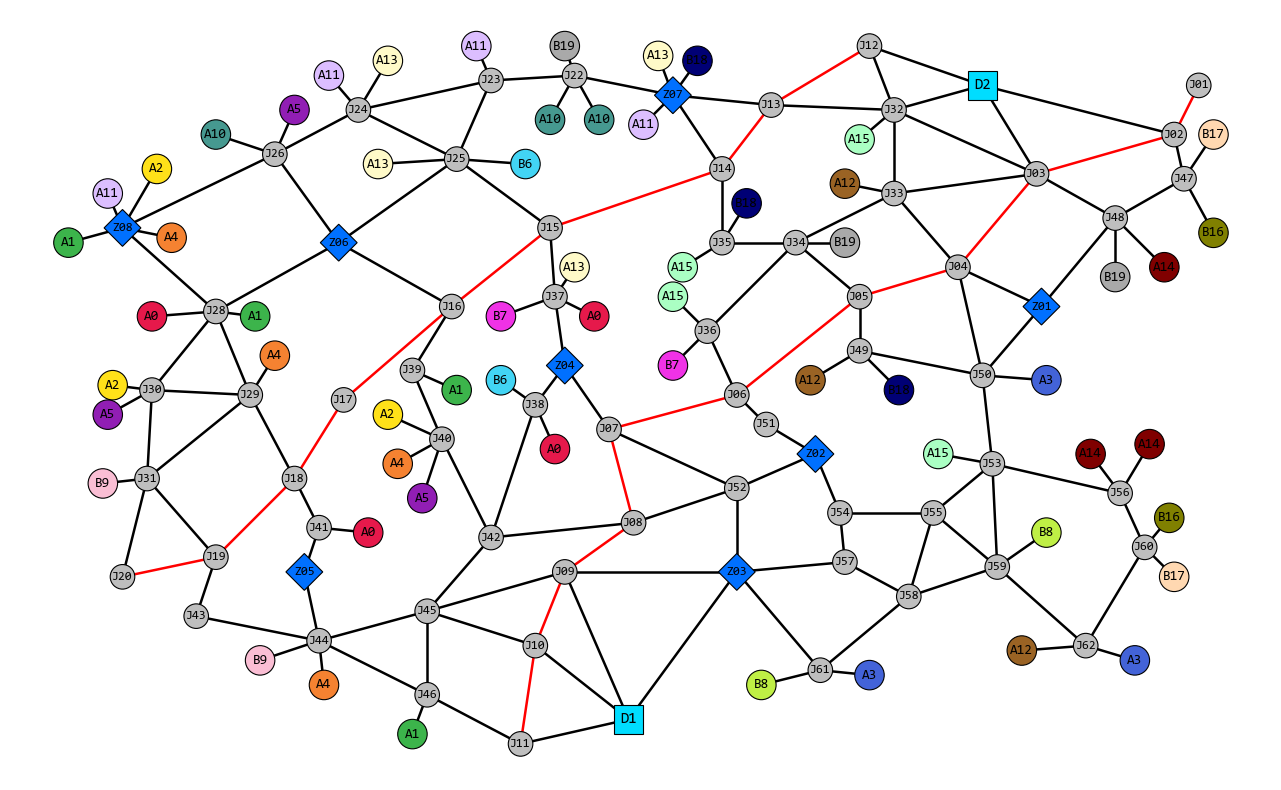

In [61]:
def find_cycle_points(A, start_point):
    # 记录已访问的节点
    visited = set()
    # 存储结果的列表
    cycle_points = []

    # 深度优先搜索
    def dfs(node):
        visited.add(node)
        cycle_points.append(node)

        for next_node in range(len(A[node])):
            if next_node not in visited and A[node][next_node] > 0.5:
                dfs(next_node)

    # 从起点开始搜索
    dfs(start_point)

    return cycle_points

# 读取模型和解
model = gp.read('./Q4solve/ModelQ4-J21J27.lp')
model.read('./Q4solve/q4Solve-J21J27 obj 11.2659.sol')

edgeMat = np.zeros((carcnts, len(Sb+Z+F+Se), len(Sb+Z+F+Se)))
maxcost = 0
cost = np.zeros((carcnts,))

for var in model.getVars():
    if var.VarName.startswith('max') or var.VarName.startswith('cost') or var.VarName.startswith('edge'):
        exec(var.VarName + '=' + str(var.Start))

# 获取图
q4g = draw_graph()

# 重新建立映射
q4map = {70:'D1', 71:'D2'}
for i in range(70):
    q4map[i] = node_number[i]
# 统计使用次数
Zusetime = {'Z01':0,'Z02':0,'Z03':0,'Z04':0,'Z05':0,'Z06':0,'Z07':0,'Z08':0}
# 预设颜色
Color = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
         '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
         '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', 
         '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']

# 路径列表
q4path_number = []

print(f"任务耗时：{round(maxcost, 3)}")
for i in I:
    # 获取每一辆喷水车的工作路径
    cg = car_category[i]
    sp = car_start[i]

    # 求路径
    q4path_number.append(find_cycle_points(edgeMat[i], sp))
    # 统计使用次数，给图片上色，改标签
    for num in q4path_number[i]:
        if node_number[num][0] == 'Z':
            Zusetime[node_number[num]] += 1
        if node_number[num][0] != 'F':
            continue
        q4g.vs[num]["label"] = f"{'A' if cg == 0 else 'B'}{i}"
        q4g.vs[num]["color"] = Color[i]
        
    q3output = "--".join([q4map[i] for i in q4path_number[i]])
    print(f"{'A' if cg == 0 else 'B'}{i}，耗时：{round(cost[i], 3)}",q3output)
    
for key, val in Zusetime.items():
    print(f"{key}使用了{val}次")

fig4, ax4 = plt.subplots(figsize=(40, 10))
ig.plot(q4g, target=ax4, layout=q4g.layout_auto(), edge_width=1.8, vertex_frame_width=0.8)
plt.savefig('Q4res.png', dpi=300, bbox_inches='tight', format='png')
plt.show()